In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# import utils
import os
# import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

Real-Time Emotion Recognition
Workflow:
* Install packages
* Download dataset
* Explore dataset
* Create Training and Validation branches
* Create CNN
* Train and evaluate model
* Test using webcam

1) Detect Faces:

In [2]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

Check whether faces are recognized

In [4]:
vid = cv2.VideoCapture(0)
print("!")
while(vid.isOpened()):
    while(True):
        ret, frame = vid.read()
        # cv2.imshow('frame', frame)
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        face = face_classifier.detectMultiScale(gray_image, scaleFactor = 1.1, minNeighbors = 5, minSize = (40,40))
        for (x,y,w,h) in face:
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0),4)
        
        # img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.imshow('bb', frame)
        # cv2.imshow('grayimg', gray_image)
        if(cv2.waitKey(1) & 0xFF == ord('q')):
            break
    vid.release()
    cv2.destroyAllWindows()
else:
    print("camera disconnected")

!
camera disconnected


2. Load and explore Dataset

Show some images of each category

In [5]:
img_size = 48
batch_size = 64

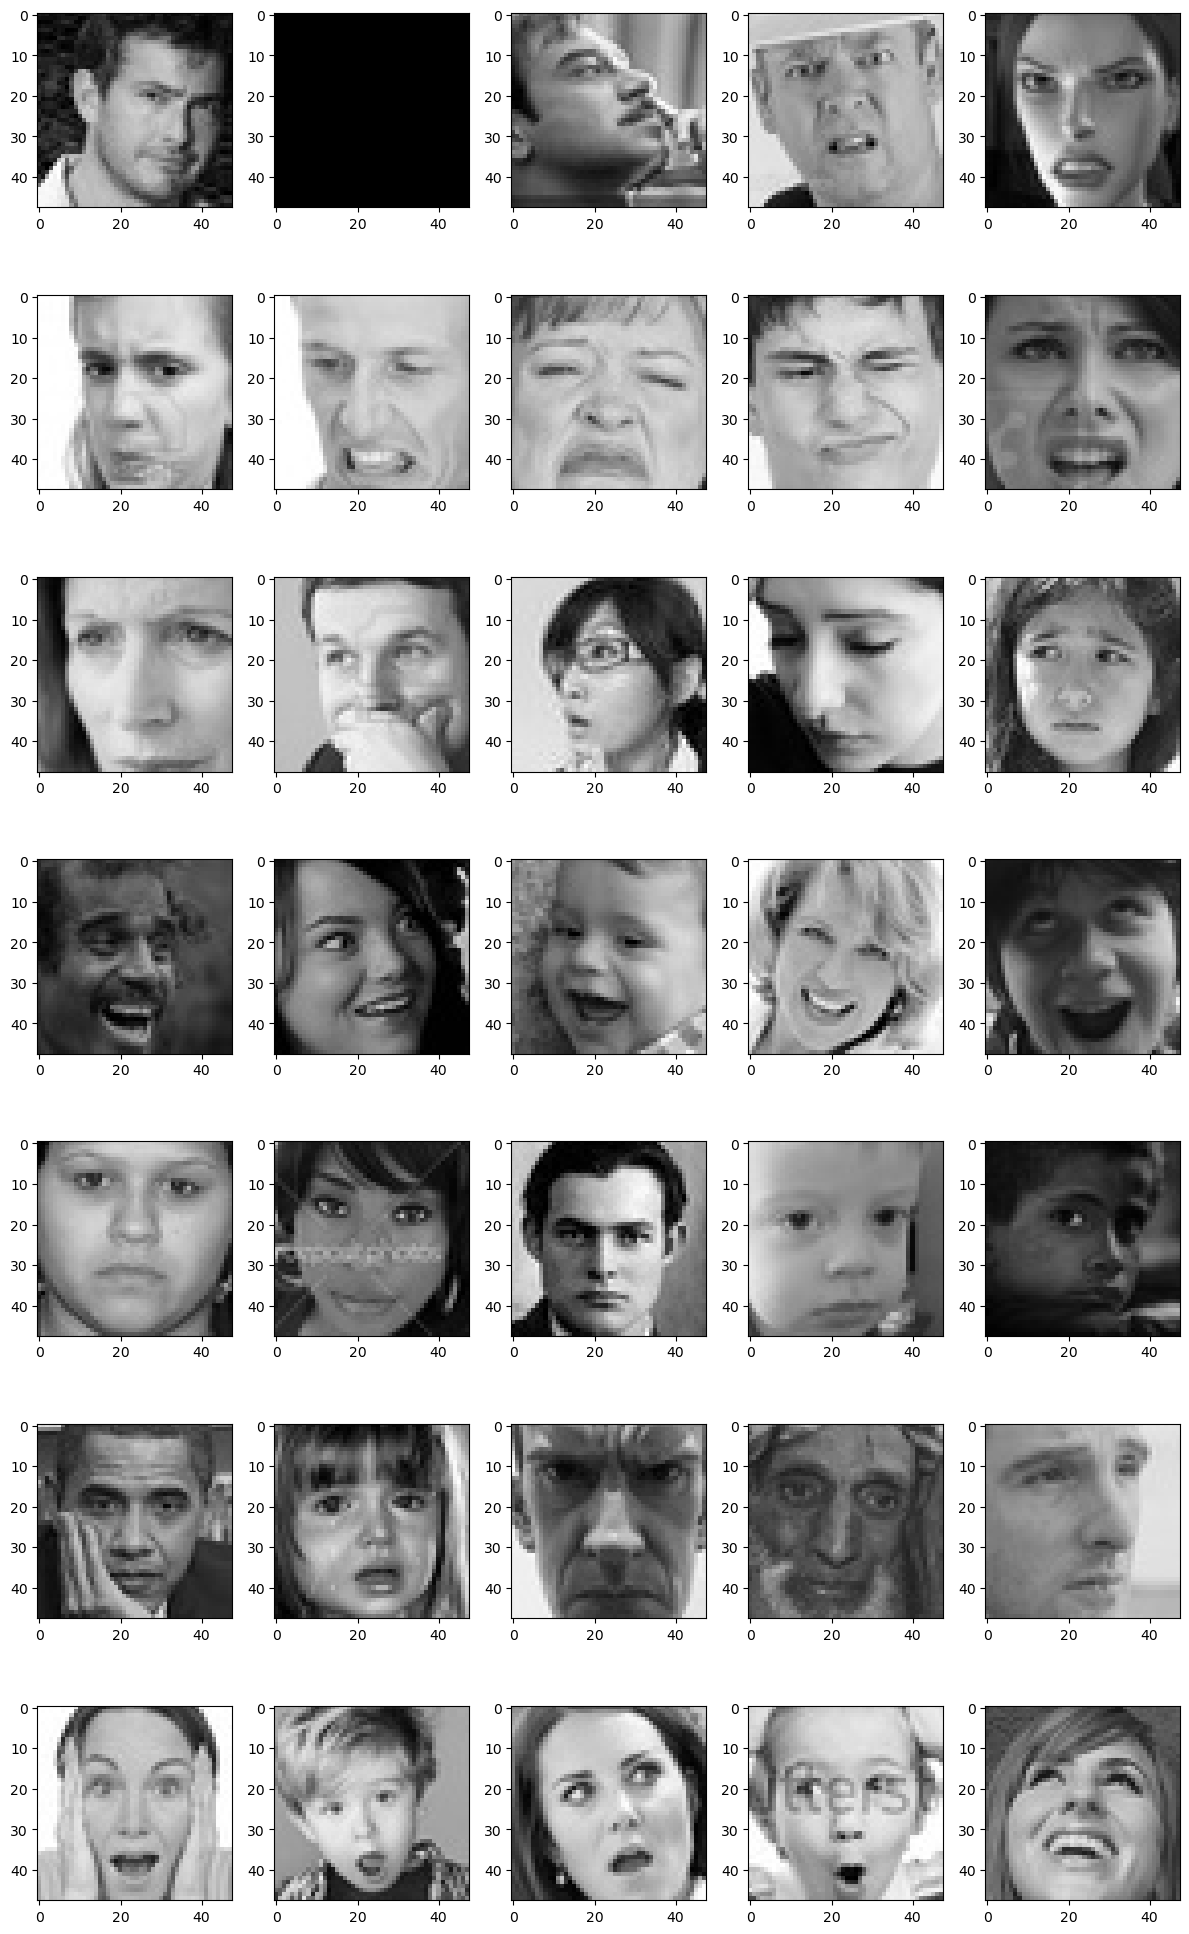

In [6]:
plt.figure(0, figsize = (12,20))
cnt = 0
for exp in os.listdir("FER/train/"):
    for i in range(1,6):
        cnt += 1
        plt.subplot(7,5,cnt)
        img = load_img("FER/train/" + exp + "/" + os.listdir("FER/train/"+exp)[i],target_size = (img_size, img_size))
        plt.imshow(img, cmap = "gray")

plt.tight_layout()
        
# img = load_img("FER/train/angry/" + os.listdir("FER/train/angry/")[1],target_size = (img_size, img_size))
# plt.imshow(img, cmap = "gray")

In [4]:
emotions_list = ["Angry","Disgust","Fear","Happy","Neutral","Sad","Surprise"]

In [7]:
for exp in os.listdir("FER/train/"):
    print(str(len(os.listdir("FER/train/" + exp))) + " "+ exp)


3995 angry
436 disgust
4097 fear
7215 happy
4965 neutral
4830 sad
3171 surprise


In [8]:
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("FER/train/", target_size = (img_size, img_size),
                                                    color_mode = "grayscale", batch_size = batch_size,
                                                   class_mode = 'categorical', shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_validation.flow_from_directory("FER/test/", target_size = (img_size, img_size),
                                                    color_mode = "grayscale", batch_size = batch_size,
                                                   class_mode = 'categorical', shuffle = False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Making CNN model:

Using a CNN model wih 4 layers

In [9]:
model = Sequential([
    #first Convolutional layer
    Conv2D(64, (3,3), padding = 'same', input_shape = (48,48,1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.25), #prevents overfitting
    
    #second convolutional layer
    Conv2D(128, (5,5), padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.25),
    
    #third Convolutional layer
    Conv2D(256, (3,3), padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.25),
    
    #fourth Convolutional layer
    Conv2D(512, (3,3), padding = 'same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.25),
    
    #flattening
    Flatten(),
    
    #First fully connected layer
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    #Second fully connected layer
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(7, activation = 'softmax')
])
optim = Adam(learning_rate = 0.0003)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

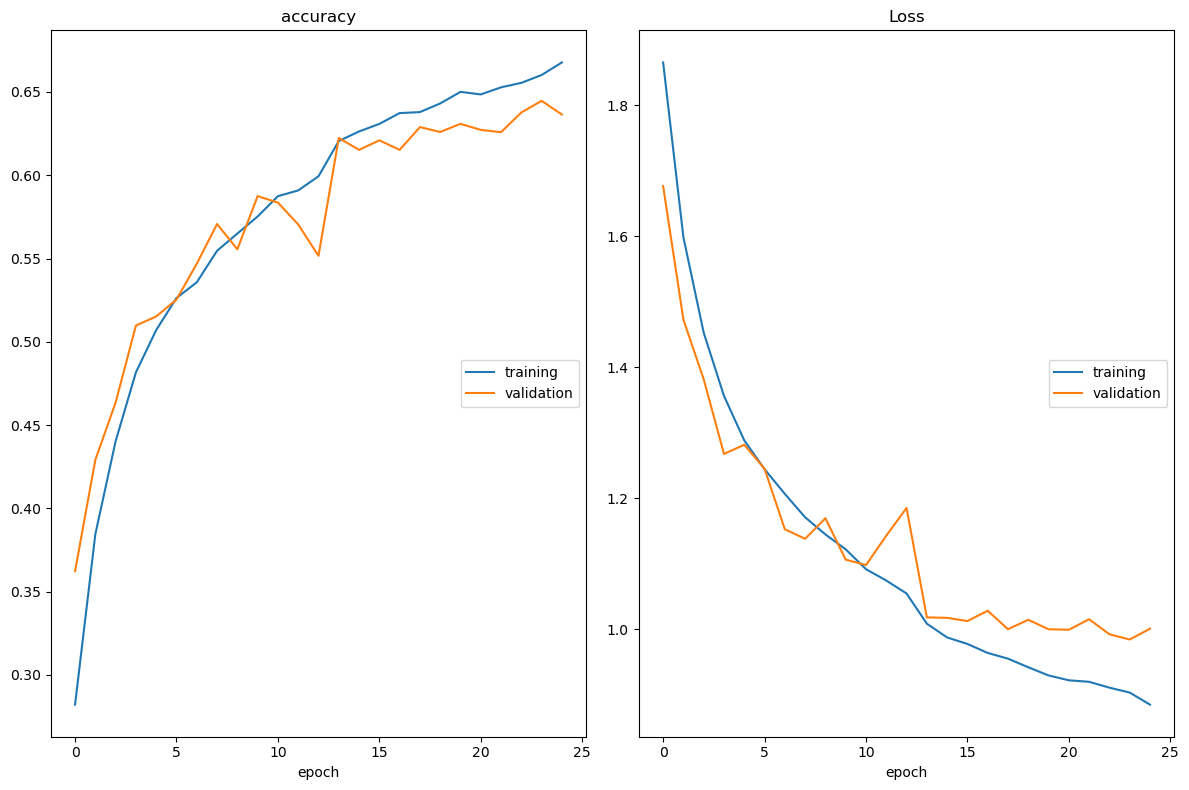

accuracy
	training         	 (min:    0.282, max:    0.668, cur:    0.668)
	validation       	 (min:    0.362, max:    0.645, cur:    0.636)
Loss
	training         	 (min:    0.885, max:    1.865, cur:    0.885)
	validation       	 (min:    0.985, max:    1.677, cur:    1.001)

Epoch 25: saving model to model_weights.h5
448/448 [==============================] - 276s 617ms/step - loss: 0.8853 - accuracy: 0.6677 - val_loss: 1.0011 - val_accuracy: 0.6364 - lr: 1.0000e-04


In [53]:
epochs = 25
steps_per_epoch = train_generator.n//train_generator.batch_size #number of samples/ batchsize, floor division(drops fractional part)
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_learning_rate = ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.0001, mode = 'auto'
)

checkpoints = ModelCheckpoint(
    "model_weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1
)

callbacks = [PlotLossesKerasTF(), checkpoints, reduce_learning_rate]

history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks
)

Loading weights from .h5 file after training

In [10]:
model.load_weights("model_weights.h5", skip_mismatch=False, by_name=False, options=None)

3. Extract faces from video input and make predictions using trained CNN model

In [ ]:
img = load_img("FER/train/angry/" + os.listdir("FER/train/angry/")[1],target_size = (48,48))
print(img.size)
arr = np.array(img)
img2 = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
plt.imshow(img2)
img2 = np.resize(img2, (48,48,1))
print(img.size)

print(model.predict(img2))

img_tensor = tf.convert_to_tensor(img, dtype = tf.uint8)
img_tensor = tf.expand_dims(img_tensor, 0)

# print(model.predict(img_tensor))

In [17]:
vid = cv2.VideoCapture(0)
print("!")
while(vid.isOpened()):
    while(True):
        ret, frame = vid.read()
        # cv2.imshow('frame', frame)
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        face = face_classifier.detectMultiScale(gray_image, scaleFactor = 1.1, minNeighbors = 5, minSize = (40,40))
        for (x,y,w,h) in face:
            cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0),4)
            # face_area = gray_image[x:x+w][y:y+h]
            # gray_face_area = cv2.cvtColor(face_area, cv2.COLOR_BGR2GRAY)
            # face_area = cv2.resize(face_area, (48, 48))
            # face_area_tf = tf.convert_to_tensor
            # preds = model.predict(face_area)
            # pred = np.argmax(preds)
            # cv2.putText(frame, emotions_list[i], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,12),2)
            
            fc = gray_image[y:y+h, x:x+w]
            roi = cv2.resize(fc, (48, 48))
            preds = model.predict(roi[np.newaxis, :, :, np.newaxis])
            pred = np.argmax(preds)
            cv2.putText(frame, emotions_list[pred], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        
        # img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.imshow('bb', frame)
        # cv2.imshow('grayimg', gray_image)
        if(cv2.waitKey(1) & 0xFF == ord('q')):
            break
    vid.release()
    cv2.destroyAllWindows()
else:
    print("camera disconnected")

!
1/1 [==============================] - 0s 20ms/step
camera disconnected
